# PO-4

Section 4: Are the phospho-peptides: Acidic-, basic-,proline-,asparagine-, or hydrophobic-directed?

# 1. Introduction <a class="anchor" id="introduction"></a>

## 1.1 Table of Contents <a class="anchor" id="table-of-contents"></a>

* [1. Introduction](#introduction)
    * [1.1 Table of Contents](#table-of-contents)
    * [1.2 Project Description](#project-description)
    * [1.3 Packages](#packages)
        * [1.3.1 Python and 3rd party libraries](#python-and-third-party-libraries)
        * [1.3.2 Custom packages](#custom-packages)
        * [1.3.3 Magic functions](#magic-functions)
        * [1.3.4 Reproducibility](#reproducibility)
* [2. Data Loading](#data-loading)
* [3. Data Exploration](#data-exploration)
* [4. Data Preprocessing](#data-preprocessing)
* [5. Modeling](#modeling)
* [6. Functions](#functions)
* [7. References](#references)
* [8. Project contribution](#project-contribution)

## 1.2 Project Description <a class="anchor" id="project-description"></a>

Brief description of what are you using in this notebook.

## 1.3 Packages <a class="anchor" id="packages"></a>

### 1.3.1 Python and 3rd party libraries <a class="anchor" id="python-and-third-party-libraries"></a>

In [1]:
import glob, os, sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc

###  1.3.2 Custom packages <a class="anchor" id="custom-packages"></a>

In [2]:
sys.path.append('./')
# from . import ., .

### 1.3.3 Magic functions <a class="anchor" id="magic-functions"></a>

In [3]:
%load_ext autoreload
%autoreload 2

### 1.3.4 Reproducibility <a class="anchor" id="reproducibility"></a>

In [4]:
#### !pip install watermark
#### rasbt watermark https://github.com/rasbt/watermark
%load_ext watermark
%watermark -a 'Fernando Pozo' -u -n -t -z -g -p pandas,numpy

!pwd

Fernando Pozo 
last updated: Mon Sep 14 2020 11:44:41 CEST 

pandas 1.0.4
numpy 1.18.5
Git hash: cefe14675e7c07123ef09f36d71551826a082e93
/local/fpozoc/projects/dev/ph-proteomics/notebooks


# 2. Data Loading <a class="anchor" id="data-loading"></a>

Treeck 

D) Phosphorylation motif analysis. Phosphorylation motif analysis was performed using the
motif-x algorithm. All identified phosphorylation motifs were classified as one of six
phosphorylation motif categories (acidic-, basic-, proline-, asparagine- or hydrophobicdirected or “other”). Motifs were assigned using binary decision tree: P in the +1 position
(proline-directed), [R/K] in the -3 position (basic), [D/E] in the +1- +3 position, >2 [D/E] in
the +1-+6 position (acidic), [F/I/L/M] in the +1 position (hydrophobic), or [N] in any
specific position over background (asparagine). See also supplementary Figure S2 and Table
S2.

In [5]:
df_exptypes = pd.read_csv('../data/interim/preprocessed_peptides.tsv.gz', compression='gzip', sep='\t')
df_exptypes['res_id'] = df_exptypes.apply(lambda row: row['proteinName'] + '-' + row['res-ptm'] + str(row['proteinSeq-loc']) + '-p', axis=1)
df_bioc = df_exptypes[['type', 'res_id', 'kmer']]

In [6]:
def generate_motifs_categories(df:list)->list:
    df[['k-drop1', 'k-6','k-5','k-4','k-3','k-2','k-1','k-ptm','k+1','k+2','k+3','k+4','k+5','k+6', 'k-drop2']] = df['kmer'].str.split('', expand=True)
    df = df.drop(['k-drop1', 'k-drop2'], axis=1)

    df.loc[df['k+1'].str.contains('P'), 'Proline-directed'] = 1

    df.loc[df['k-3'].str.contains('R|K'), 'Basic'] = 1

    for column in df[df.columns[6:9]]:
        df.loc[df[column].str.contains('D|E'), 'Acidic'] = 1

    for column in df[df.columns[10:16]]:
        df.loc[df[column].str.contains('D|E'), 'Acidic'] = 1

    df.loc[df['k+1'].str.contains('F|I|L|M'), 'Hydrophobic'] = 1

    for column in df[df.columns[3:16]]:
        df.loc[df[column].str.contains('N'), 'Asparagine'] = 1

    df.loc[df['Proline-directed'] == 1, df.columns[17:]] = 0
    df.loc[df['Basic'] == 1, df.columns[18:]] = 0
    df.loc[df['Acidic'] == 1, df.columns[19:]] = 0
    df.loc[df['Hydrophobic'] == 1, df.columns[20:]] = 0
    df = df.fillna(0)
    df_results = df[df.columns[16:]].sum(axis=0).reset_index().rename(columns={'index':'Category', 0:'n'})
    df_results.loc[5] = ['Unclassified', df[df.columns[16:]].sum(axis=1).value_counts()[0]]
    df_results['p'] = (df_results['n']/df_results['n'].sum())*100
    return df_results.drop('n', axis=1)

In [7]:
df_motcat_wt = generate_motifs_categories(df_bioc.loc[df_bioc['type'] == 'wt']).rename(columns={'p': 'Motif category proportion (WT)'})
df_motcat_ko = generate_motifs_categories(df_bioc.loc[df_bioc['type'] == 'ko']).rename(columns={'p': 'Motif category proportion (KO)'})

In [8]:
df_motcats = pd.merge(df_motcat_wt, df_motcat_ko, on='Category').set_index('Category')

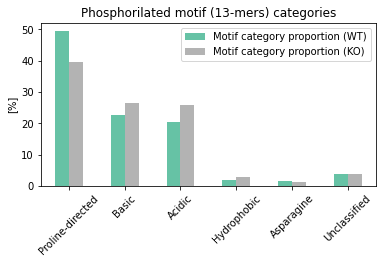

In [9]:
df_motcats.plot.bar(rot=45, figsize=(6,3), colormap='Set2')
plt.xlabel('')
plt.ylabel('[%]')
plt.title('Phosphorilated motif (13-mers) categories')
plt.savefig('../reports/figures/figure3A.png', bbox_inches='tight', dpi=360)

In [10]:
df_motcats

,Motif category proportion (WT),Motif category proportion (KO)
Category,,
Proline-directed,49.549116,39.639924
Basic,22.784658,26.405559
Acidic,20.355898,25.963361
Hydrophobic,1.863653,2.874289
Asparagine,1.659252,1.295009
Unclassified,3.787423,3.821857


Brief data source explanation.

# 3. Data Exploration <a class="anchor" id="data-exploration"></a>

Descriptive statistics, plots, and figures.

# 4. Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

Once the data has been right understood follow some preprocessing guidelines.

# 5. Modeling <a class="anchor" id="modeling"></a>

Apply a model in necessary

# 6. Functions <a class="anchor" id="functions"></a>

In [10]:
def foo(arg1, arg2, arg3):
    return list1

# 7. References <a class="anchor" id="references"></a>

That's the initial reference for this notebook: https://github.com/dair-ai/data_science_writing_primer/blob/master/Writing_Primer_for_Data_Scientists.ipynb

Below, give the reader references to follow properly your work.
- Reference 1.
- Reference 2.

# 8. Project contribution <a class="anchor" id="project-contribution"></a>

**Author information**:
Fernando Pozo ([@fpozoc](https://gitlab.com/fpozoc))

You can find the data driven project jupyter notebook template [here](https://gitlab.com/fpozoc/data-driven-project-template/-/blob/master/notebooks/1.0-nb_template.ipynb).